# Figure comparing weights, pressures and star formation rate surface densities for Figure 13 in Jeffreson et al. 2024b

In [1]:
import numpy as np
import h5py
from scipy.stats import binned_statistic_2d

import sys, glob, re

sys.path.append('../')
import astro_helper as ah

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')

# Load the data

In [5]:
# high-res files
file = '/n/holystore01/LABS/loeb_lab/Users/sjeffreson/MW-tracers/snap-DESPOTIC_400.hdf5'

# rebin onto 80pc 3D grid

In [135]:
def collect_tau_deps(file, width_kpc=30., height_kpc=0.5, scale_kpc=0.08):
    x_bins = np.linspace(-width_kpc/2., width_kpc/2., int(width_kpc/scale_kpc)+1) * ah.kpc_to_cm
    y_bins = np.linspace(-width_kpc/2., width_kpc/2., int(width_kpc/scale_kpc)+1) * ah.kpc_to_cm
    z_bins = np.linspace(-height_kpc/2., height_kpc/2., 2) * ah.kpc_to_cm

    f = h5py.File(file, "r")
    SFR = f['PartType0']['StarFormationRate'][:] * f['PartType0']['StarFormationRate'].attrs['to_cgs']
    mass = f['PartType0']['Masses'][:] * f['PartType0']['Masses'].attrs['to_cgs']
    x = (f['PartType0']['Coordinates'][:,0] - 0.5 * f['Header'].attrs['BoxSize']) * f['PartType0']['Coordinates'].attrs['to_cgs']
    y = (f['PartType0']['Coordinates'][:,1] - 0.5 * f['Header'].attrs['BoxSize']) * f['PartType0']['Coordinates'].attrs['to_cgs']
    R = np.sqrt(x**2 + y**2)
    z = (f['PartType0']['Coordinates'][:,2] - 0.5 * f['Header'].attrs['BoxSize']) * f['PartType0']['Coordinates'].attrs['to_cgs']

    # divide into z-slices
    SFRs = np.zeros((len(z_bins)-1, len(x_bins)-1, len(y_bins)-1))
    masses = np.zeros((len(z_bins)-1, len(x_bins)-1, len(y_bins)-1))
    for i in range(len(z_bins)-1):
        cnd = (z >= z_bins[i]) & (z < z_bins[i+1]) & (R < width_kpc/2. * ah.kpc_to_cm)
        SFRs[i], x_edges, y_edges, _ = binned_statistic_2d(
            x[cnd], y[cnd],
            SFR[cnd]/ah.Msol_to_g,
            bins=(x_bins, y_bins),
            statistic='sum'
        )
        masses[i], x_edges, y_edges, _ = binned_statistic_2d(
            x[cnd], y[cnd],
            mass[cnd]/ah.Msol_to_g,
            bins=(x_bins, y_bins),
            statistic='sum'
        )

    tau_deps = masses/SFRs
    tau_deps[tau_deps == np.inf] = np.nan
    return tau_deps, SFRs

In [150]:
tau_deps, SFRs = collect_tau_deps(file, scale_kpc=0.75, height_kpc=0.2)

/tmp/ipykernel_720872/2277582660.py:32: RuntimeWarning: divide by zero encountered in divide
  tau_deps = masses/SFRs
/tmp/ipykernel_720872/2277582660.py:32: RuntimeWarning: invalid value encountered in divide
  tau_deps = masses/SFRs


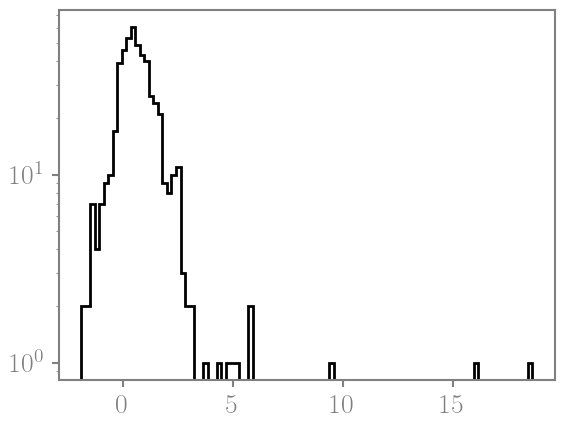

In [151]:
plt.hist(np.log10(tau_deps[~np.isnan(tau_deps)].flatten()/ah.Gyr_to_s), bins=100, histtype='step', color='k', lw=2)
plt.yscale('log')
plt.show()

In [152]:
def collect_tau_dyns(file, width_kpc=30., height_kpc=0.5, scale_kpc=0.08):
    x_bins = np.linspace(-width_kpc/2., width_kpc/2., int(width_kpc/scale_kpc)+1) * ah.kpc_to_cm
    y_bins = np.linspace(-width_kpc/2., width_kpc/2., int(width_kpc/scale_kpc)+1) * ah.kpc_to_cm
    z_bins = np.linspace(-height_kpc/2., height_kpc/2., 2) * ah.kpc_to_cm

    f = h5py.File(file, "r")
    x = ((f['PartType0']['Coordinates'][:,0] - 0.5 * f['Header'].attrs['BoxSize']) * f['PartType0']['Coordinates'].attrs['to_cgs'])
    y = ((f['PartType0']['Coordinates'][:,1] - 0.5 * f['Header'].attrs['BoxSize']) * f['PartType0']['Coordinates'].attrs['to_cgs'])
    R = np.sqrt(x**2 + y**2)
    z = ((f['PartType0']['Coordinates'][:,2] - 0.5 * f['Header'].attrs['BoxSize']) * f['PartType0']['Coordinates'].attrs['to_cgs'])
    x_s = np.concatenate((
        f['PartType2']['Coordinates'][:,0] - 0.5 * f['Header'].attrs['BoxSize'],
        f['PartType3']['Coordinates'][:,0] - 0.5 * f['Header'].attrs['BoxSize']
    )) * f['PartType2']['Coordinates'].attrs['to_cgs']
    y_s = np.concatenate((
        f['PartType2']['Coordinates'][:,1] - 0.5 * f['Header'].attrs['BoxSize'],
        f['PartType3']['Coordinates'][:,1] - 0.5 * f['Header'].attrs['BoxSize']
    )) * f['PartType2']['Coordinates'].attrs['to_cgs']
    vx = f['PartType0']['Velocities'][:,0] * f['PartType0']['Velocities'].attrs['to_cgs']
    vy = f['PartType0']['Velocities'][:,1] * f['PartType0']['Velocities'].attrs['to_cgs']
    vz = f['PartType0']['Velocities'][:,2] * f['PartType0']['Velocities'].attrs['to_cgs']
    vtheta = -y*vx + x*vy
    Omega = vtheta / (x**2 + y**2)
    mass = f['PartType0']['Masses'][:] * f['PartType0']['Masses'].attrs['to_cgs']
    mass_s = np.concatenate((
        f['PartType2']['Masses'][:] * f['PartType2']['Masses'].attrs['to_cgs'],
        f['PartType3']['Masses'][:] * f['PartType3']['Masses'].attrs['to_cgs']
    ))

    # divide into z-slices
    sigmaEffs = np.zeros((len(z_bins)-1, len(x_bins)-1, len(y_bins)-1))
    Omegas = np.zeros((len(z_bins)-1, len(x_bins)-1, len(y_bins)-1))
    surfdenses = np.zeros((len(z_bins)-1, len(x_bins)-1, len(y_bins)-1))
    surfdenses_s = np.zeros((len(z_bins)-1, len(x_bins)-1, len(y_bins)-1))
    for i in range(len(z_bins)-1):
        cnd = (z >= z_bins[i]) & (z < z_bins[i+1]) & (R < width_kpc/2. * ah.kpc_to_cm)
        vzmean, x_edges, y_edges, binnumber = binned_statistic_2d(
            x[cnd], y[cnd],
            vz[cnd],
            bins=(x_bins, y_bins),
            statistic='mean',
            expand_binnumbers=True
        )
        vz_minus_mean = vz[cnd] - vzmean[binnumber[0]-1, binnumber[1]-1]
        sigmaEffs[i], x_edges, y_edges, _ = binned_statistic_2d(
            x[cnd], y[cnd],
            vz_minus_mean**2,
            bins=(x_bins, y_bins),
            statistic='mean'
        )
        sigmaEffs[i] = sigmaEffs[i]**0.5

        Omegas[i], x_edges, y_edges, _ = binned_statistic_2d(
            x[cnd], y[cnd],
            Omega[cnd],
            bins=(x_bins, y_bins),
            statistic='mean'
        )
        surfdenses[i], x_edges, y_edges, _ = binned_statistic_2d(
            x, y,
            mass,
            bins=(x_bins, y_bins),
            statistic='sum'
        )
        surfdenses[i] = surfdenses[i] / (scale_kpc * ah.kpc_to_cm)**2
        surfdenses_s[i], x_edges, y_edges, _ = binned_statistic_2d(
            x_s, y_s,
            mass_s,
            bins=(x_bins, y_bins),
            statistic='sum'
        )
        surfdenses_s[i] = surfdenses_s[i] / (scale_kpc * ah.kpc_to_cm)**2

    # Using Equation (22) from old version of Sultan's paper, i.e. same equilibrium assumptions
    # as PRFM to compute the dynamical time
    tau_dyn = 4.*sigmaEffs / (
        np.pi * ah.G_cgs * (surfdenses + surfdenses_s) + ((np.pi * ah.G_cgs)**2 * (surfdenses + surfdenses_s)**2 + 8./3. * Omegas**2 * sigmaEffs**2)**0.5
    )
    tau_dyn[tau_dyn == np.inf] = np.nan
    tau_dyn[tau_dyn == 0] = np.nan
    return tau_dyn

In [153]:
tau_dyns = collect_tau_dyns(file, scale_kpc=0.75, height_kpc=0.2)

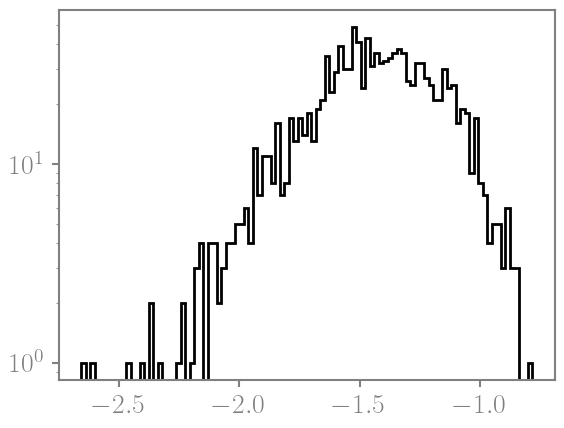

In [154]:
plt.hist(np.log10(tau_dyns[~np.isnan(tau_dyns)].flatten()/ah.Gyr_to_s), bins=100, histtype='step', color='k', lw=2)
plt.yscale('log')
plt.show()

# figure

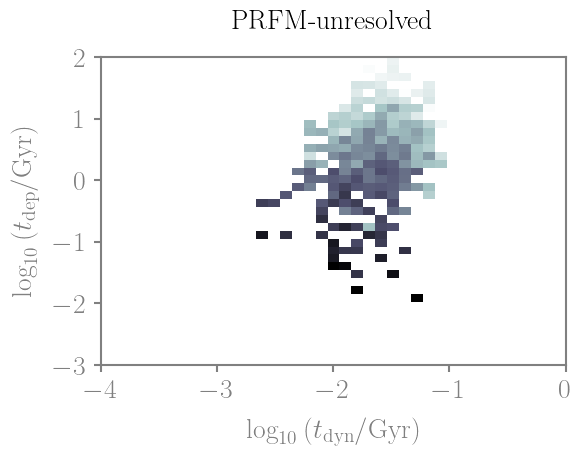

In [156]:
# 2D histogram of tau_dyn (x-axis) vs. tau_dep (y-axis) for PRFM and control (SH03) case,
# on two separate axes
fig, ax = plt.subplots(1, 1, figsize=(6,4))

# hist2D with log scale on 3rd axis
frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(np.ravel(tau_dyns)/ah.Gyr_to_s), np.log10(np.ravel(tau_deps)/ah.Gyr_to_s),
    np.ravel(SFRs), statistic='sum',
    bins=(np.linspace(-4., 0., 40), np.linspace(-3., 2., 40))
)
frac_SFR /= np.sum(frac_SFR)
ax.imshow(frac_SFR.T, origin='lower',
             extent=(-4., 0., -3., 2.), aspect='auto',
             cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-5, vmax=1.e-1))
ax.set_xlabel(r'$\log_{10}{(t_{\rm dyn}/{\rm Gyr})}$')
ax.set_ylabel(r'$\log_{10}{(t_{\rm dep}/{\rm Gyr})}$')
ax.set_title('PRFM-unresolved', pad=20, fontsize=20)

plt.show()